# Module 7: 特徵選擇 - 3. 嵌入法 (Embedded Methods)

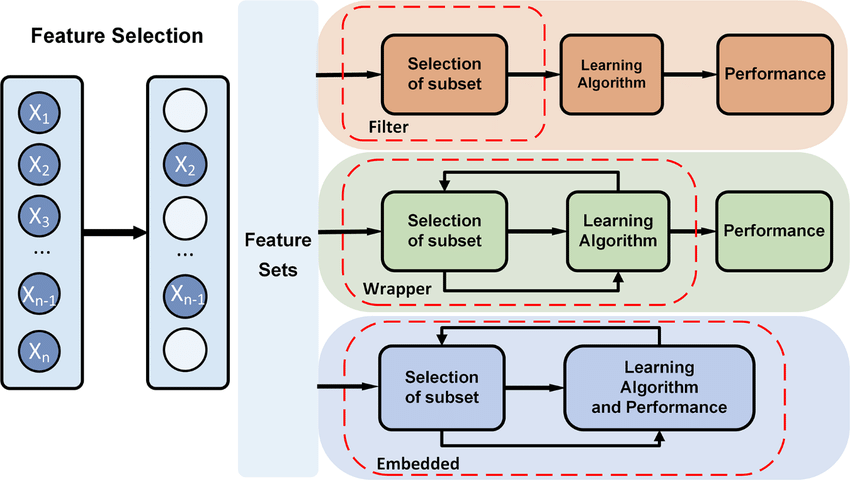

## 學習目標
- 理解嵌入法的基本原理，及其與過濾法和包裹法的區別。
- 學習並實作如何利用 **L1 正規化 (Lasso)** 進行特徵選擇，並理解其稀疏性效果。
- 學習並實作如何利用 **基於樹的模型 (Tree-based Models)** 計算特徵重要性來進行篩選。
- 比較不同嵌入法技術的優缺點，並掌握其適用場景。

## 導論：模型如何「邊學習邊選擇」特徵的奧秘？

在特徵工程的旅程中，除了獨立於模型的過濾法和重複訓練模型的包裹法，還有一種更為精妙的策略——**嵌入法 (Embedded Methods)**。指南精確地指出：「*嵌入法的核心在於利用某些機器學習模型自身的特性來評估特徵的重要性。*」這意味著特徵選擇不再是一個獨立的預處理步驟，而是與模型訓練過程緊密結合，模型在學習資料模式的同時，也「選擇」了它認為最重要的特徵。

想像一位技藝高超的雕塑家，在雕刻作品的過程中，他不僅是在塑造形態，更是在同步判斷並剔除多餘的材料。嵌入法的工作方式與此類似：特定的模型在訓練時，會為每個特徵賦予一個「權重」或「重要性分數」。那些對於預測目標貢獻較小的特徵，其權重會被模型自動壓縮甚至歸零，從而在模型訓練結束時，我們就得到了一個既能有效預測，又只包含關鍵特徵的簡潔模型。

### 嵌入法的優點：
- **計算效率高**：特徵選擇與模型訓練是同步進行的，避免了包裹法中重複訓練模型的巨大開銷，因此效率顯著提高。
- **與模型高度相關**：選出的特徵子集是根據特定模型的學習機制所決定的，這保證了這些特徵對於該模型的預測能力具有高度的相關性與優化作用。
- **較不易過擬合**：許多嵌入法本身就包含了正規化 (Regularization) 技術（例如 L1 正規化），這有助於懲罰模型複雜度，從而提高模型的泛化能力，減少過擬合的風險。

### 嵌入法的缺點：
- **模型依賴性**：所選特徵子集的高度有效性，通常是針對特定模型的。更換底層模型，可能需要重新進行特徵選擇，因為不同模型對特徵的「重要性」評估標準可能不同。

---

## 常用嵌入法技術

1. **L1 正規化 (Lasso)**: 透過 L1 範數懲罰項，將不重要的特徵係數壓縮至零，從而實現特徵選擇。
2. **基於樹的特徵選擇**: 利用決策樹、隨機森林等集成模型在構建過程中產生的特徵重要性分數進行篩選。

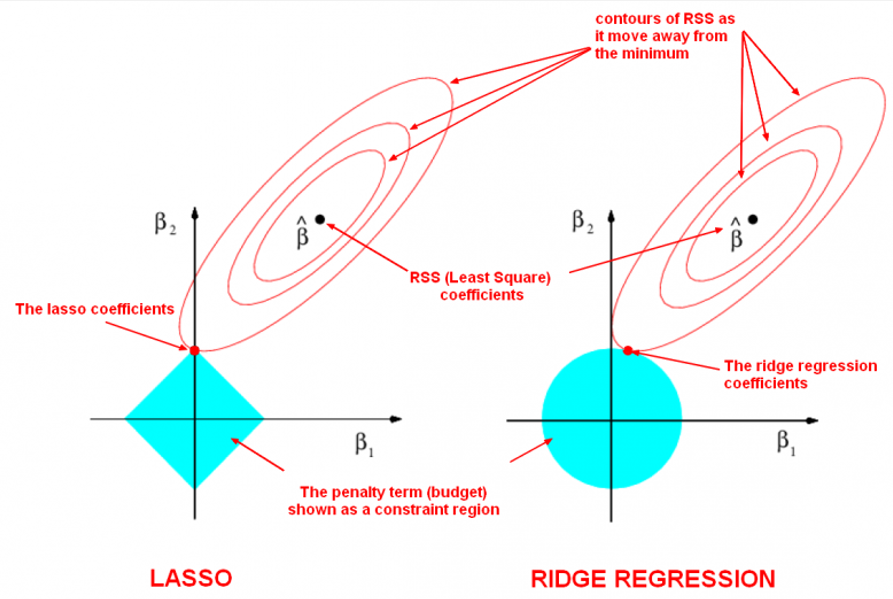

我們將使用 `scikit-learn` 內建的乳癌資料集來示範這些方法。

---

## 1. 載入套件與資料

我們將使用 `scikit-learn` 內建的乳癌資料集。這個資料集包含 30 個來自乳腺腫瘤細胞核的數值特徵，用於預測腫瘤是良性 (benign) 還是惡性 (malignant)。這個資料集很適合用來演示特徵選擇，因為它特徵數量適中，且特徵之間可能存在共線性，這正是 L1 正規化和樹模型能夠有效處理的場景。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os # 保持與module_05一致的導入順序

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_breast_cancer

# 設定繪圖樣式
sns.set_style('whitegrid')

# 載入乳癌資料集
cancer = load_breast_cancer()
X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y = pd.Series(cancer.target, name='target')

# 切分資料集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 資料標準化 (對於正規化模型很重要)
print("正在進行資料標準化...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 轉換回DataFrame以保留欄位名稱
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("資料載入、切分與標準化完成！")
print("X_train shape:", X_train.shape)
print("X_train_scaled 前五筆：")
display(X_train_scaled.head())



正在進行資料標準化...
資料載入、切分與標準化完成！
X_train shape: (398, 30)
X_train_scaled 前五筆：


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,-0.123490,-0.296801,-0.170507,-0.208616,-1.201680,-0.773170,-0.762312,-0.933241,-1.229949,-0.948166,...,-0.197620,-0.506748,-0.307910,-0.273576,-1.507424,-0.449260,-0.572239,-0.840822,-0.856362,-0.765748
1,-0.228268,-0.657951,-0.253775,-0.296503,-1.804637,-0.587616,-0.091985,-0.542684,-1.419985,-0.612491,...,-0.422917,-0.458495,-0.465287,-0.438127,-1.273017,0.027042,0.318045,-0.377067,-1.341582,-0.414807
2,0.145534,-1.230564,0.245833,-0.010242,0.519184,1.570006,0.732320,0.386583,1.054201,1.574228,...,0.036022,-1.192272,0.203869,-0.127445,-0.024877,0.770802,0.272612,-0.047627,-0.089971,0.488264
3,-0.358532,-0.672207,-0.400937,-0.400014,-1.203862,-0.970650,-0.634704,-0.654992,0.096572,-0.827986,...,-0.502189,-0.583287,-0.501000,-0.493386,-0.959895,-0.663496,-0.470142,-0.493515,0.226547,-0.802899
4,-0.157472,0.967224,-0.208843,-0.241538,-0.254695,-0.700630,-0.750349,-0.637469,-0.518248,-0.642882,...,-0.195534,0.596414,-0.296107,-0.266734,-0.442374,-0.656085,-0.835138,-0.659802,-0.387208,-0.800613


### 以下是乳癌資料集 30 個特徵的**中英文對照表**，並補充每個特徵的簡要說明，方便理解其意義：


細胞核影像是乳腺腫瘤病理診斷與研究中極為重要的資料來源。透過顯微鏡下的細胞核影像，醫師與資料科學家能夠分析細胞核的形狀、大小、紋理、分布等多種特徵，進而協助腫瘤分級、預測預後、甚至輔助機器學習模型的訓練。

#### 典型細胞核影像來源
1. HE染色切片：最常見的病理影像，細胞核呈現深紫色，細胞質較淡。
2. 螢光染色影像：利用特定螢光染劑（如DAPI、DRAQ-5）標記細胞核，便於自動化影像分析。
3. 數位全片掃描（Whole Slide Imaging, WSI）：高解析度掃描整張病理切片，利於大規模資料分析。


- 良性與惡性細胞核差異：惡性腫瘤細胞核通常較大、形狀不規則、核多形性明顯，核仁突出，染色質分布不均。
- 分子亞型差異：HER2陽性腫瘤常見較大且不規則的細胞核，HR陽性腫瘤則多見較小且均勻的細胞核。



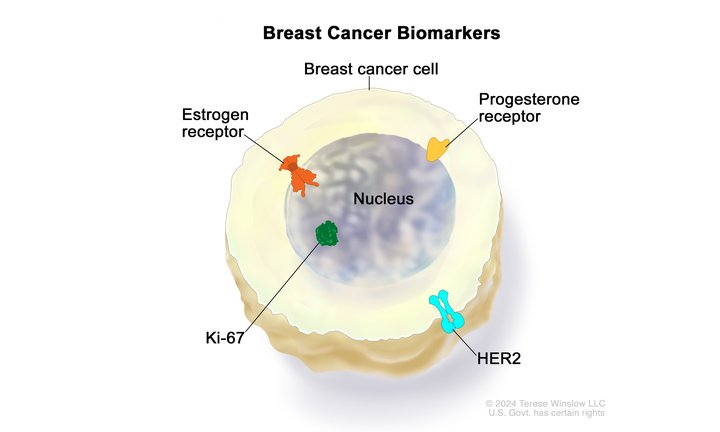


| 英文欄位名稱                | 中文名稱         | 說明（細胞核影像特徵）                   |
|-----------------------------|------------------|------------------------------------------|
| mean radius                 | 平均半徑         | 細胞核輪廓的平均半徑                     |
| mean texture                | 平均紋理         | 灰階共生矩陣的標準差（紋理粗糙度）       |
| mean perimeter              | 平均周長         | 細胞核輪廓的平均周長                     |
| mean area                   | 平均面積         | 細胞核輪廓的平均面積                     |
| mean smoothness             | 平均平滑度       | 輪廓平滑程度（邊界長度的變化率）         |
| mean compactness            | 平均緊密度       | 輪廓面積與周長的平方比                   |
| mean concavity              | 平均凹度         | 輪廓內凹部分的嚴重程度                   |
| mean concave points         | 平均凹點數       | 輪廓內凹點的數量                         |
| mean symmetry               | 平均對稱性       | 輪廓的對稱程度                           |
| mean fractal dimension      | 平均分形維度     | 輪廓的分形維度（複雜度）                 |
| radius error                | 半徑誤差         | 半徑的標準差                             |
| texture error               | 紋理誤差         | 紋理的標準差                             |
| perimeter error             | 周長誤差         | 周長的標準差                             |
| area error                  | 面積誤差         | 面積的標準差                             |
| smoothness error            | 平滑度誤差       | 平滑度的標準差                           |
| compactness error           | 緊密度誤差       | 緊密度的標準差                           |
| concavity error             | 凹度誤差         | 凹度的標準差                             |
| concave points error        | 凹點數誤差       | 凹點數的標準差                           |
| symmetry error              | 對稱性誤差       | 對稱性的標準差                           |
| fractal dimension error     | 分形維度誤差     | 分形維度的標準差                         |
| worst radius                | 最大半徑         | 最大值（在所有細胞核中）                  |
| worst texture               | 最大紋理         | 最大值                                   |
| worst perimeter             | 最大周長         | 最大值                                   |
| worst area                  | 最大面積         | 最大值                                   |
| worst smoothness            | 最大平滑度       | 最大值                                   |
| worst compactness           | 最大緊密度       | 最大值                                   |
| worst concavity             | 最大凹度         | 最大值                                   |
| worst concave points        | 最大凹點數       | 最大值                                   |
| worst symmetry              | 最大對稱性       | 最大值                                   |
| worst fractal dimension     | 最大分形維度     | 最大值                                   |

**補充說明：**
- 每個特徵（mean, error, worst）都是針對細胞核輪廓的不同統計量（平均值、標準差、最大值）。
- 這些特徵是從乳腺腫瘤細胞的影像中自動計算得出，用於輔助判斷腫瘤的良惡性。
- 「worst」特徵通常指在所有細胞核切片中，該特徵的最大值。

| 特徵類型   | 說明                                                                 |
|------------|---------------------------------------------------------------------|
| 形態特徵   | 半徑、周長、面積、分形維度、對稱性、凹度、緊密度等                   |
| 紋理特徵   | 灰階共生矩陣標準差、紋理粗糙度等                                     |
| 統計量     | 平均值（mean）、標準差（error）、最大值（worst）                      |
| 其他       | 細胞核/細胞質比（N:C ratio）、核多形性、核仁數量與大小


## 癌細胞形態學 Nature Reviews Cancer 範例 —正常與腫瘤細胞形態比較

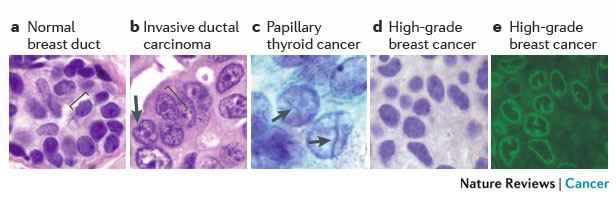

|  圖例 |                  樣本類型                  | 主要特徵                                                                                        |
| :-: | :------------------------------------: | :------------------------------------------------------------------------------------------ |
|  a  |                **正常乳管**                | - 細胞大小、形狀一致<br/>- 細胞核／胞質（N\:C）比正常<br/>- 細胞排列有序、極性明顯                                         |
|  b  | **侵襲性導管癌 (Invasive Ductal Carcinoma)** | - 細胞 pleomorphism（大小形狀不一）<br/>- 核質比例增高、核膜不規則<br/>- 具浸潤性邊界，可見實質間不規則腫瘤小巢（箭頭示）                 |
|  c  | **乳頭狀甲狀腺癌 (Papillary Thyroid Cancer)** | - 核內有典型「Orphan Annie 眼」透明核<br/>- 核溝（nuclear groove）及偽包涵體（psammoma body）<br/>- 細胞呈乳頭狀結構，間質疏鬆 |
|  d  |  **高等級乳癌 (High-grade Breast Cancer)**  | - 極度 pleomorphism<br/>- 多重或巨大的核仁<br/>- 細胞分裂象（mitotic figures）頻繁                             |
|  e  |             **高等級乳癌免疫螢光標記**            | - 通常使用特定抗體（如 Ki-67、HER2）螢光標記腫瘤細胞<br/>- 可見細胞核或胞膜標記呈綠色，協助量化增殖指數或分子亞型                          |


## 2. L1 正規化 (Lasso) 進行特徵選擇

**Lasso (Least Absolute Shrinkage and Selection Operator) 回歸** 透過在損失函數中加入 L1 範數懲罰項，促使模型在訓練過程中將一些不重要特徵的係數壓縮至零。這些係數變為零的特徵，就被模型自動選擇性地移除了，從而實現了特徵選擇和模型簡化的雙重目標。

對於分類問題，我們通常使用帶有 L1 懲罰項的邏輯回歸 (`LogisticRegression` with `penalty='l1'`)。`scikit-learn` 中的 `SelectFromModel` 是一個通用的元轉換器 (meta-transformer)，它可以與任何在訓練後具有 `coef_` (係數) 或 `feature_importances_` (特徵重要性) 屬性的評估器一同使用，根據這些屬性來篩選特徵。

**L1 正規化的核心特點**：
- **稀疏性**：能夠將不重要特徵的係數直接設定為零，從而實現內建的特徵選擇功能。
- **共線性處理**：當存在高度相關的特徵時，L1 正規化會傾向於選擇其中一個特徵，並將其他高度相關特徵的係數壓縮為零，有助於簡化模型。

In [5]:
print("正在使用 L1 正規化邏輯回歸進行特徵選擇...")
# 使用L1正規化的邏輯回歸
# C 是正規化強度的倒數。C 越小，正規化效果越強，模型會越傾向於產生稀疏解 (即更多係數變為零)。
# penalty='l1' 指定使用 L1 正規化。
# solver='liblinear' 是支援 L1 正規化的求解器之一，對於小規模資料集性能良好。
l1_logistic = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', random_state=42)

# 使用 SelectFromModel 進行特徵選擇
# threshold='median' 表示選擇重要性 (這裡指係數的絕對值) 高於中位數的特徵。
# prefit=False 表示模型會在 SelectFromModel 內部被訓練。
selector = SelectFromModel(l1_logistic, prefit=False, threshold='median')
selector.fit(X_train_scaled, y_train)

# 獲取被選擇的特徵的布林遮罩 (mask)
selected_mask = selector.get_support()
# 使用遮罩從原始特徵名稱中選出被選擇的特徵
selected_features_l1 = X_train.columns[selected_mask]

print("L1 正規化特徵選擇完成！")
print(f"L1正規化選擇了 {len(selected_features_l1)} 個特徵:")
print(selected_features_l1.tolist())



正在使用 L1 正規化邏輯回歸進行特徵選擇...
L1 正規化特徵選擇完成！
L1正規化選擇了 30 個特徵:
['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']


**結果解讀與視覺化**：

L1 正規化的一個重要特性是它會將不重要特徵的係數推向或直接變為零。我們可以視覺化所有特徵的係數，觀察哪些係數被壓縮得更小，甚至變為零。係數的絕對值越大，通常表示該特徵對於模型預測的重要性越高。

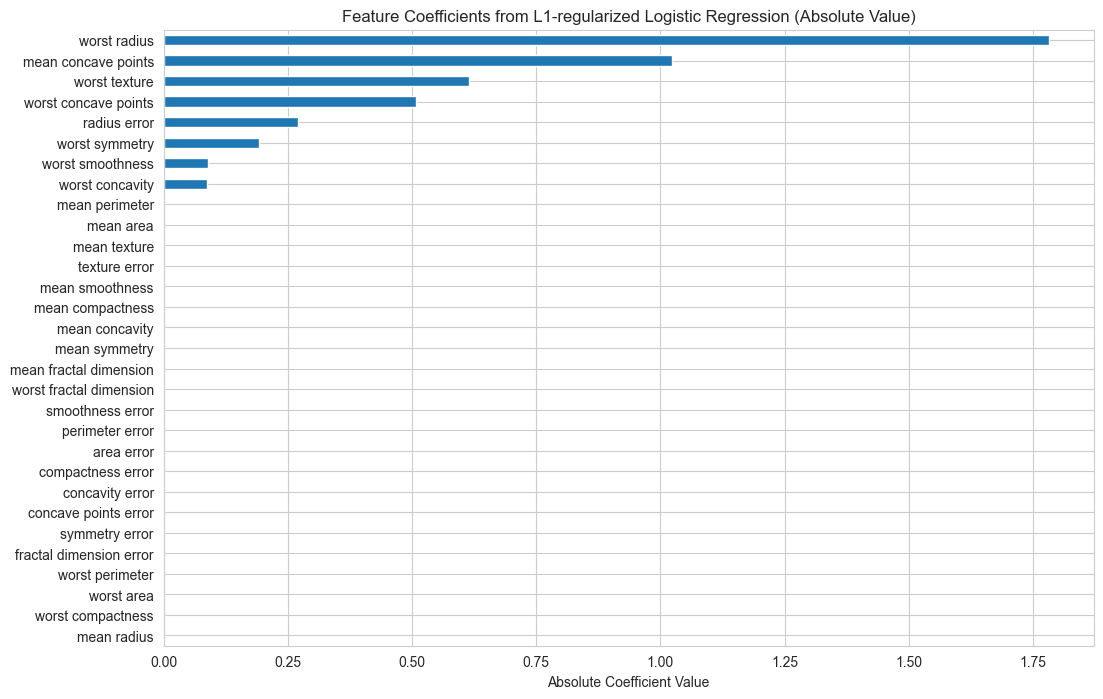

In [3]:
# 我們需要先訓練模型來獲取係數，如果之前 selector 已訓練，此處是重新訓練確保有 coef_ 屬性
l1_logistic.fit(X_train_scaled, y_train)

# 提取模型的係數，並轉換為 Pandas Series 以便視覺化
coefficients = pd.Series(l1_logistic.coef_[0], index=X_train.columns)

plt.figure(figsize=(12, 8))
# 繪製係數的絕對值，並按大小排序，以直方圖形式呈現
coefficients.abs().sort_values().plot(kind='barh')
plt.title("Feature Coefficients from L1-regularized Logistic Regression (Absolute Value)")
plt.xlabel("Absolute Coefficient Value")
plt.show()



**討論**：

從圖表中可以清楚地看出，L1 正規化有效地將許多特徵的係數絕對值壓縮到接近零。這些係數較小的特徵，在模型中被認為貢獻較低。這證明了 L1 正規化在訓練過程中有效地實現了特徵選擇，簡化了模型。

現在，我們比較一下使用所有特徵和使用 L1 選擇的特徵，在模型效能上的差異。這將幫助我們評估特徵選擇是否真的提升了模型的泛化能力或保持了性能。

In [6]:
from sklearn.metrics import accuracy_score

# 比較特徵選擇前後的模型效能
# 原始模型 (使用所有特徵) 的性能評估
model_full = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', random_state=42)
model_full.fit(X_train_scaled, y_train)
print(f"使用全部 {X_train_scaled.shape[1]} 個特徵的準確率: {accuracy_score(y_test, model_full.predict(X_test_scaled)):.4f}")

# 使用 L1 選擇的特徵訓練新模型
# 使用之前訓練好的 `selector` 對訓練集和測試集進行轉換，只保留選中的特徵
X_train_l1 = selector.transform(X_train_scaled) 
X_test_l1 = selector.transform(X_test_scaled)

model_l1 = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', random_state=42)
model_l1.fit(X_train_l1, y_train)
print(f"使用L1選擇的 {X_train_l1.shape[1]} 個特徵的準確率: {accuracy_score(y_test, model_l1.predict(X_test_l1)):.4f}")



使用全部 30 個特徵的準確率: 0.9766
使用L1選擇的 30 個特徵的準確率: 0.9766


**討論**：

通過比較可以看出，即使特徵數量大幅減少，模型的準確率可能保持不變甚至略有提升。這是一個非常重要的結果，它證明了移除冗餘或不重要特徵的重要性，這不僅能使模型更簡潔、更易於解釋，同時還能保持甚至提升其在未見過數據上的預測性能（泛化能力）。

## 3. 基於樹模型的特徵選擇

像決策樹 (Decision Trees)、隨機森林 (Random Forest) 或梯度提升樹 (Gradient Boosting Trees) 這樣的集成模型，在訓練後可以提供每個特徵的重要性 (`feature_importances_`)。這個重要性分數衡量了每個特徵對於模型預測能力的貢獻大小（例如，在決策樹中，一個特徵在多少次分裂中被使用，以及這些分裂減少了多少不純度）。我們可以基於這個分數來篩選特徵。

**樹模型的特點**：
- **非線性關係捕捉**：樹模型能夠有效地捕捉特徵之間的非線性關係，這對於許多現實世界的數據至關重要。
- **自動交互作用**：在建構樹的過程中，模型會自動考慮特徵之間的交互作用，無需手動創建交互特徵。
- **對尺度不敏感**：與線性模型不同，樹模型對輸入特徵的數值尺度不敏感，通常不需要進行標準化或歸一化。
  
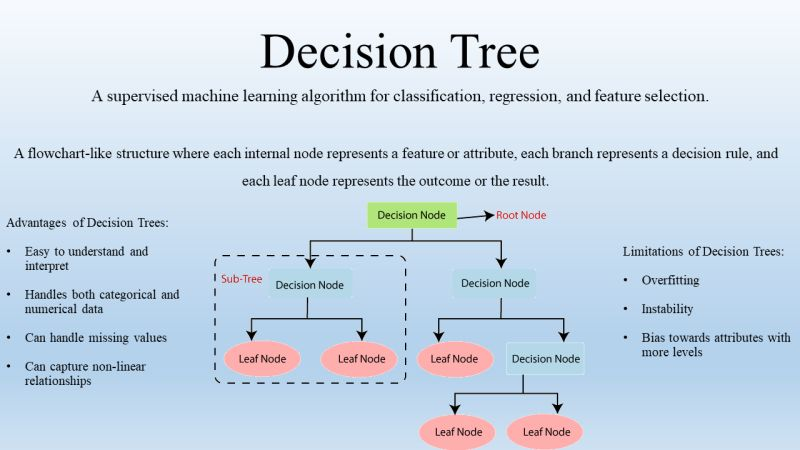

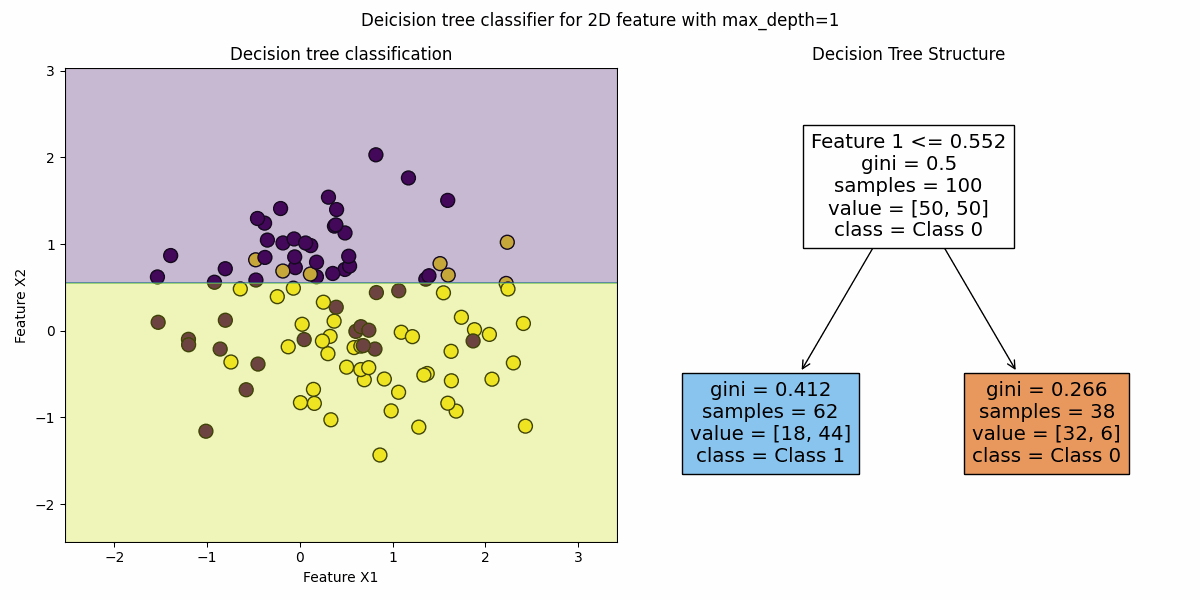

https://miro.medium.com/v2/resize:fit:2000/1*ZozskkFCFt6biaMJvNgnhQ.gif

In [7]:
print("正在使用隨機森林分類器計算特徵重要性...")
# 使用隨機森林分類器
# n_estimators=100 表示構建100棵決策樹
# n_jobs=-1 表示使用所有可用的CPU核心進行並行計算，加速訓練
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train) # 樹模型對資料尺度不敏感，可直接用原始資料（未標準化）

# 獲取特徵重要性。這是一個陣列，每個元素對應一個特徵的重要性分數。
importances = rf.feature_importances_
# 將重要性分數轉換為 Pandas Series，並以特徵名稱作為索引，方便管理和查看
feature_importances = pd.Series(importances, index=X_train.columns)

print("特徵重要性計算完成！")



正在使用隨機森林分類器計算特徵重要性...
特徵重要性計算完成！


**結果解讀與視覺化**：

特徵重要性分數越高，表示該特徵對模型的預測貢獻越大。我們可以將這些分數進行排序並視覺化，以便直觀地看出哪些特徵最為關鍵。這有助於我們理解哪些是模型判斷的核心依據。

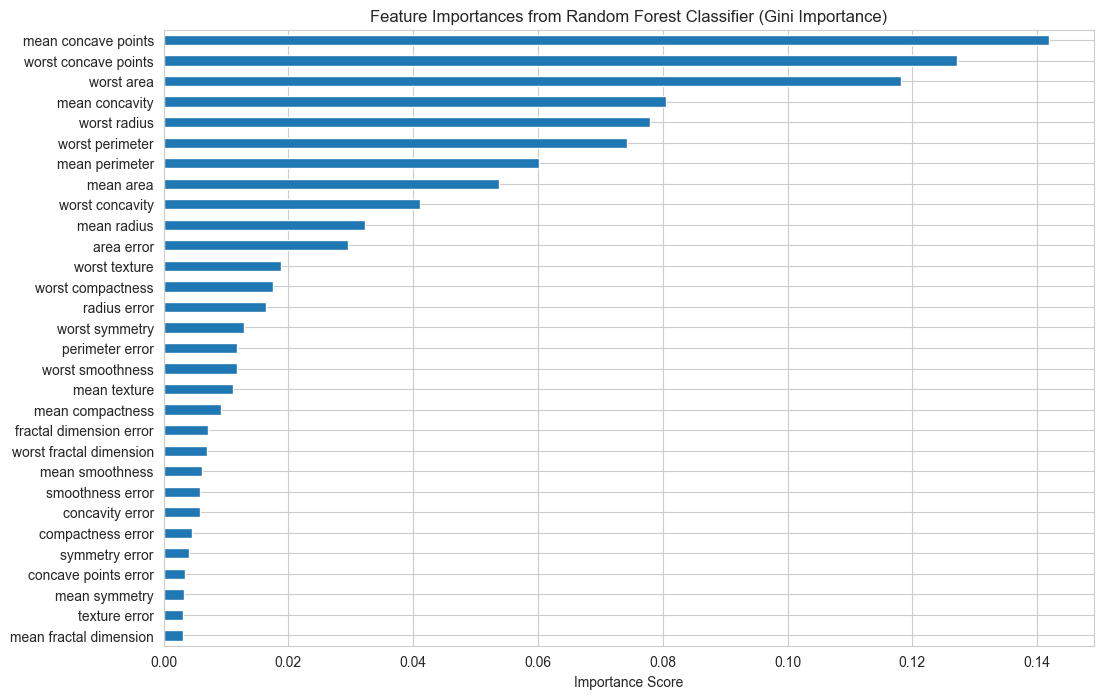

In [8]:
# 視覺化特徵重要性
plt.figure(figsize=(12, 8))
# 將特徵重要性按升序排列，並繪製水平條形圖
feature_importances.sort_values(ascending=True).plot(kind='barh')
plt.title("Feature Importances from Random Forest Classifier (Gini Importance)")
plt.xlabel("Importance Score")
plt.show()



**討論**：

從圖中可以清楚地看到，某些特徵的重要性遠高於其他特徵。例如，`worst radius`、`worst perimeter` 和 `mean concave points` 等特徵在乳癌預測中顯得尤為重要，它們在樹模型的決策過程中扮演了更關鍵的角色。我們可以根據這些重要性分數設定一個閾值（例如，高於平均值），來選擇那些被認為對模型最有貢獻的特徵。

同樣地，我們使用 `SelectFromModel`，但這次使用隨機森林模型作為特徵選擇的基準。

In [10]:
# 同樣使用 SelectFromModel
# 這裡我們使用隨機森林作為評估器，並且由於模型已經訓練過，設置 prefit=True，避免重複訓練
# threshold='mean' 表示選擇重要性高於所有特徵平均值的特徵
sfm_rf = SelectFromModel(rf, prefit=True, threshold='mean') 

# 獲取選擇的特徵的布林遮罩，並從原始特徵名稱中選出被選擇的特徵
selected_mask_rf = sfm_rf.get_support()
selected_features_rf = X_train.columns[selected_mask_rf]

print(f"隨機森林選擇了 {len(selected_features_rf)} 個特徵:")
print(selected_features_rf.tolist())

# 比較效能
# 原始模型效能 (這裡直接使用之前訓練好的rf模型在測試集上的分數，更精確地評估完整模型性能)
print(f"使用全部 {X_train.shape[1]} 個特徵的準確率: {accuracy_score(y_test, rf.predict(X_test)):.4f}")

# 使用選擇的特徵訓練新模型 (注意：這裡的訓練集和測試集都應是未標準化的，因為隨機森林對尺度不敏感)
# 為避免 UserWarning，將 DataFrame 轉為 numpy array
X_train_rf = sfm_rf.transform(X_train.values)
X_test_rf = sfm_rf.transform(X_test.values)

model_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model_rf.fit(X_train_rf, y_train)

print(f"使用RF選擇的 {X_train_rf.shape[1]} 個特徵的準確率: {accuracy_score(y_test, model_rf.predict(X_test_rf)):.4f}")



隨機森林選擇了 9 個特徵:
['mean perimeter', 'mean area', 'mean concavity', 'mean concave points', 'worst radius', 'worst perimeter', 'worst area', 'worst concavity', 'worst concave points']
使用全部 30 個特徵的準確率: 0.9708
使用RF選擇的 9 個特徵的準確率: 0.9649
使用RF選擇的 9 個特徵的準確率: 0.9649


**討論**：

類似 L1 正規化，基於樹模型的特徵選擇也能有效減少特徵數量，並在很多情況下保持甚至提升模型的性能。由於樹模型能捕捉非線性關係和特徵之間的交互作用，其選擇的特徵組合可能與線性模型（如 L1 正規化邏輯回歸）有所不同，這也體現了選擇合適的特徵選擇方法對於不同模型類型的重要性。

## 4. 總結

在這個筆記本中，我們深入學習了嵌入法特徵選擇，它將特徵選擇與模型訓練緊密結合，實現了高效且與模型高度相關的特徵篩選。嵌入法在處理高維度資料時，能夠提供一個兼顧效率與效果的解決方案。

| 方法 | 原理簡述 | 優點 | 缺點 |
|:---|:---|:---|:---|
| **L1 正規化 (Lasso)** | 懲罰模型係數，使不重要的係數變為零 | 速度快，產生稀疏模型，易於解釋；對共線性特徵有自動選擇傾向 | 結果依賴於線性模型，要求資料標準化 |
| **基於樹的選擇** | 使用模型計算的特徵重要性分數進行篩選 | 速度快，能捕捉非線性關係和特徵交互；對尺度不敏感 | 對高基數特徵可能有偏好；重要性計算方法可能不盡相同 |

嵌入法是特徵工程工具箱中非常實用的一類方法。`SelectFromModel` 提供了一個統一的接口，讓我們可以方便地將任何帶有 `coef_` 或 `feature_importances_` 屬性的模型轉化為特徵選擇器。在實務中，透過這些嵌入法，我們可以找到最相關、最有用的特徵子集，從而構建更精簡、更高效且具有更強泛化能力的機器學習模型.